# Distribution of the lengths of the proteins
**for the different species (reference proteomes)**

## Import python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats 

import sys
sys.path.append('../lib/')
import constants as c

## The protein length distributions for the different species

### Retrieving the statistical descriptions of the length's distributions

In [2]:
# statistics on length distribution for different species     
#stat_file = "../main_tables/stat_proteins.tsv"
stat_file = c.MAIN_TABLES_PATH + c.STAT_P_FILE
print("The statistical descriptions of the protein distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["superregnum", "species", "proteome_id", "tax_id", "uniprot_fasta_file", "count", "mean", "var", "division_both_dbs", "log10_mean", "log10_var"]]

# visualize data
if 1:
    pd.set_option('display.max_columns', None)
    display(stat_df.head(2))
    print(stat_df.shape)
    print(stat_df["division_both_dbs"].value_counts())

The statistical descriptions of the protein distributions for the different species is in:
 ../main_tables/stat_proteins.tsv 



,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
0,archaea,Halorubrum saccharovorum,UP000053331,2248,/ftp.uniprot.org/pub/databases/uniprot/current...,2334.0,250.641817,28808.608041,archaea,2.310023,0.078739
1,archaea,Pyrodictium occultum,UP000053352,2309,/ftp.uniprot.org/pub/databases/uniprot/current...,1602.0,285.092385,34816.348736,archaea,2.372852,0.073136


(9913, 11)
division_both_dbs
bacteria       7997
fungi           772
archaea         330
vertebrates     248
metazoa         226
plants          184
protists        156
Name: count, dtype: int64


## Python functions

In [3]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [4]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel, dist_of): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)

    c_hex = c.COLOR_FOR_DIST[dist_of]
    count, bins, *rest = plt.hist(log10_len, 50, density=True, 
                                  alpha=0.8, color=c_hex, edgecolor='silver') # plot 60 bins
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); #plt.ylim([0,2.0])
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [5]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [6]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_df, tax_id, dist_of):
    species_df = get_df_for_taxid(stat_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)

    # retrieve lengths 
    lengths_f = c.GENES_PROTS_LENGTH_PATH + species_df["uniprot_fasta_file"].item() 
    lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
    # retrieve data
    lens_df = pd.read_csv(lengths_f, sep="\t")
    lens_df = lens_df[["length"]]
    
    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(lens_df.head(2))
        print(lens_df.shape)
    
    # plot the distributions: observed and theoretical
    lens_df["log10_length"] = lens_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize() + ". " + species_df["division_both_dbs"].item().capitalize(); subtitle = "Proteins";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    plot_log_norm (lens_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), int(species_df["count"].item()), 
                   title, subtitle, xlabel, ylabel, dist_of)  
    # fit to normal
    does_it_fits_normal(lens_df["log10_length"])

## Distributions for different species:

### _Homo sapiens_ (tax_id = 9606)

#### Retrieve its statistical description

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
8585,eukaryota,Homo sapiens (Human),UP000005640,9606,/ftp.uniprot.org/pub/databases/uniprot/current...,20614.0,552.845105,354913.157154,vertebrates,2.601146,0.125239


µ: 2.6011463573824893 	σ: 0.3538905693139241


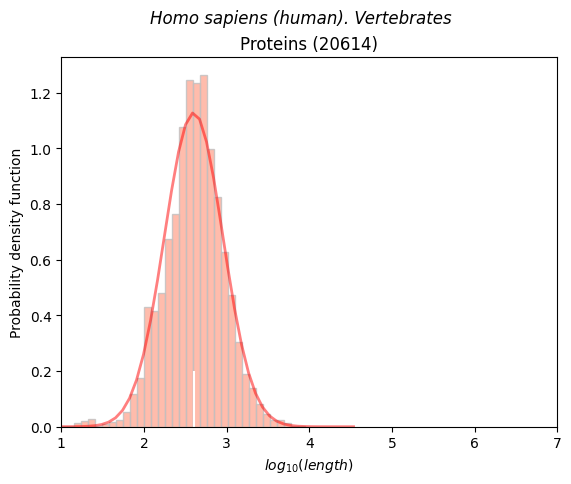

Kurtosis: 1.163832716732534
Skewness: -0.26039124808735764
D'Agostino's K-squared test(statistics=717.1684257602484, p-value=1.8571844920422435e-156)


In [7]:
tax_id = 9606
species_distribution__retrieve_plot_and_fit(stat_df, tax_id, "proteins")

## Fig. 1

### _Danio rerio_ (tax_id = 7955)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
8528,eukaryota,Danio rerio (Zebrafish) (Brachydanio rerio),UP000000437,7955,/ftp.uniprot.org/pub/databases/uniprot/current...,25706.0,538.158329,315453.463435,vertebrates,2.599115,0.114029


µ: 2.599115440779346 	σ: 0.3376817874330292


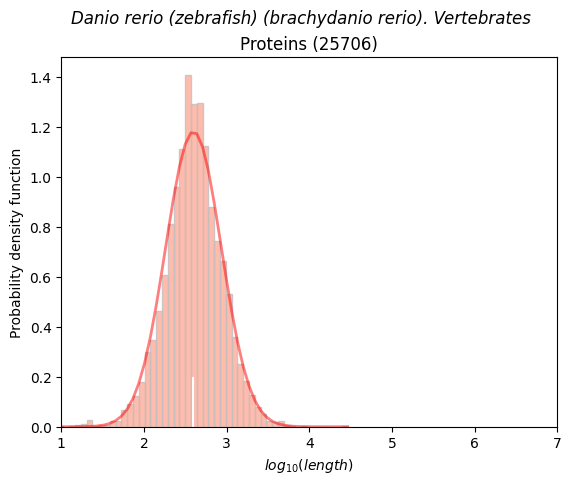

Kurtosis: 0.8752018347236281
Skewness: -0.138739152539118
D'Agostino's K-squared test(statistics=494.0354527107476, p-value=5.267014471006957e-108)


In [8]:
tax_id = 7955
species_distribution__retrieve_plot_and_fit(stat_df, tax_id, "proteins")

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
8618,eukaryota,Cavia porcellus (Guinea pig),UP000005447,10141,/ftp.uniprot.org/pub/databases/uniprot/current...,18247.0,540.943169,246132.162669,vertebrates,2.6082,0.107282


µ: 2.6081999542155296 	σ: 0.3275391435998644


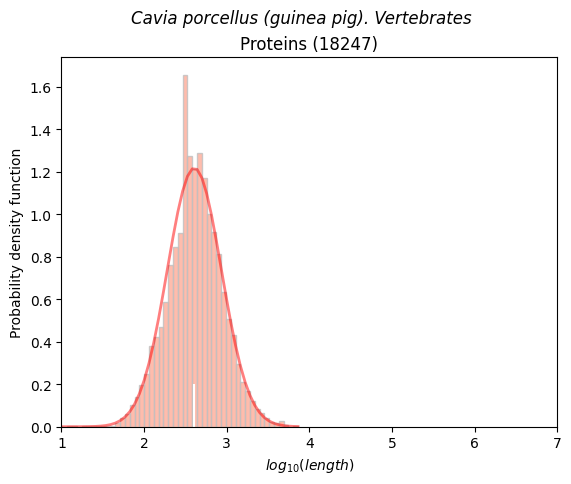

Kurtosis: 0.453719686546751
Skewness: -0.02500681788721736
D'Agostino's K-squared test(statistics=107.87728120235484, p-value=3.7561767965780544e-24)


In [9]:
tax_id = 10141
species_distribution__retrieve_plot_and_fit(stat_df, tax_id, "proteins")

## Fig S7

### _Shewanella loihica_ (tax\_id = 323850)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
1734,bacteria,Shewanella loihica (strain ATCC BAA-1088 / PV-4),UP000001558,323850,/ftp.uniprot.org/pub/databases/uniprot/current...,3855.0,339.778729,60661.644073,bacteria,2.440595,0.079555


µ: 2.4405946049463645 	σ: 0.28205457432966796


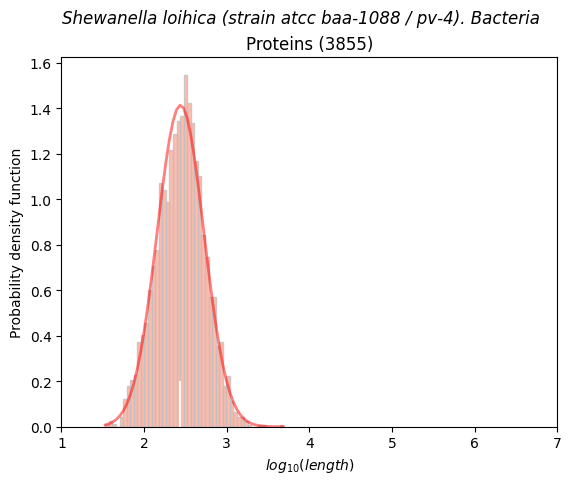

Kurtosis: -0.09329483526783733
Skewness: -0.04857619394836839
D'Agostino's K-squared test(statistics=2.9239278013247283, p-value=0.23178063331967275)


In [10]:
tax_id = 323850
species_distribution__retrieve_plot_and_fit(stat_df, tax_id, "proteins")

### _Orchesella cincta_ (tax\_id = 48709)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,division_both_dbs,log10_mean,log10_var
8785,eukaryota,Orchesella cincta (Springtail),UP000094527,48709,/ftp.uniprot.org/pub/databases/uniprot/current...,20218.0,424.12019,156494.930996,metazoa,2.495977,0.115681


µ: 2.4959771728410467 	σ: 0.3401194732115712


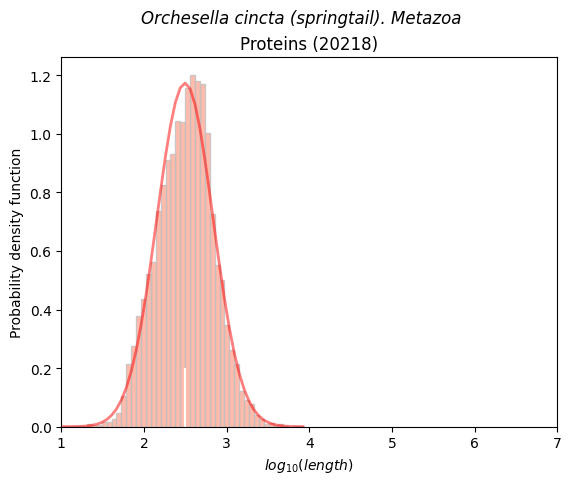

Kurtosis: 0.07804696175054904
Skewness: -0.07578260990627901
D'Agostino's K-squared test(statistics=24.185233843939038, p-value=5.600711459410769e-06)


In [11]:
tax_id = 48709
species_distribution__retrieve_plot_and_fit(stat_df, tax_id, "proteins")